In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as npimg 
import numpy as np
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import cv2
import glob
import matplotlib.patches as patches
from scipy import signal as sg
import utils
%matplotlib inline

In [245]:
rgb = utils.load_image('./test_images/test2.jpg')
hls = cv2.cvtColor(rgb, cv2.COLOR_RGB2HLS)
yuv = cv2.cvtColor(rgb, cv2.COLOR_RGB2YUV)
hsv = cv2.cvtColor(rgb, cv2.COLOR_RGB2HSV)

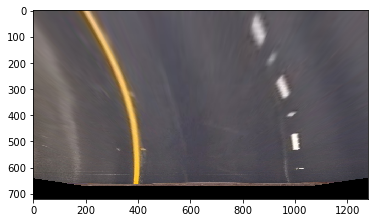

In [246]:
plt.imshow(first2bird(rgb))
plt.show()

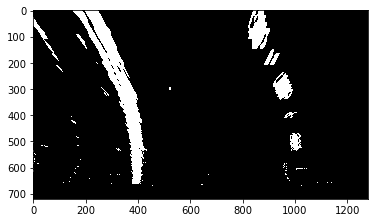

In [247]:
sobel_all = OR_binaryimage(sobelthis(rgb[:,:,0]), OR_binaryimage(sobelthis(rgb[:,:,2]), sobelthis(rgb[:,:,1])))
combined_all = OR_binaryimage(yellowandwhite(hsv), sobel_all)
plt.imshow(first2bird(combined_all), cmap='gray')
plt.show()

In [248]:
window_ready = first2bird(combined_all)

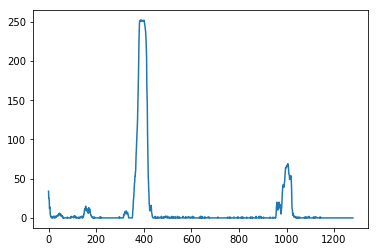

In [249]:
image_height, image_width  = window_ready.shape
midpoint = np.int(image_width/2)

# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(window_ready[int(4*image_height/7):,:], axis=0)
plt.plot(histogram)

leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

In [250]:
leftx_base, rightx_base

(386, 1005)

In [251]:
def coord2box(coord1, coord2):
    
    if coord2[:]<coord1[:]:
        temp = coord1
        coord1 = coord2
        coord2 = temp
        
    height = coord2[0]-coord1[0]
    width = coord2[1]-coord1[1]
    
    return (coord1[0], coord1[1]), height, width

In [265]:
num_windows = 20
window_height = image_height/num_windows

#number of pixels to the left and right of the center spike. ie window_width/2
window_offset = 50

In [266]:
leftx, rightx = leftx_base, rightx_base
leftleft, leftright, rightleft, rightright = leftx-window_offset, leftx+window_offset, rightx-window_offset, rightx+window_offset
lane_lines = np.zeros_like(window_ready)
boxs = []

for y_high in range(int(num_windows*window_height), 0, int(-window_height)):
    y_low = int(y_high-window_height)
    
    lhistogram = np.sum(window_ready[y_low:y_high,leftleft:leftright], axis=0)
    rhistogram = np.sum(window_ready[y_low:y_high,rightleft:rightright], axis=0)
    
    if np.max(lhistogram):
        leftx = np.argmax(lhistogram)+leftleft
    if np.max(rhistogram):
        rightx = np.argmax(rhistogram)+rightleft
    
    leftleft, leftright, rightleft, rightright = leftx-window_offset, leftx+window_offset, rightx-window_offset, rightx+window_offset
    
    boxs += coord2box([leftleft,y_low],[leftright,y_high]), coord2box([rightleft,y_low],[rightright,y_high])
    
    lane_lines[y_low:y_high, leftleft: leftright] =  window_ready[y_low:y_high, leftleft:leftright] 
    lane_lines[y_low:y_high, rightleft:rightright] = window_ready[y_low:y_high, rightleft:rightright] 


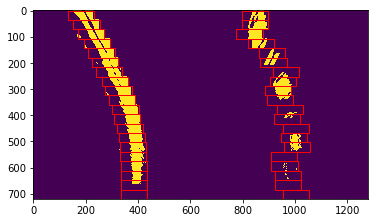

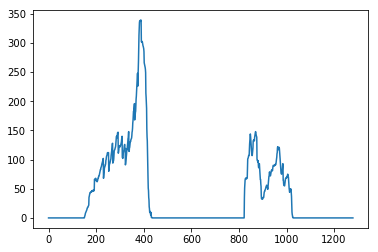

In [267]:
fig,ax = plt.subplots(1)
ax.imshow(lane_lines)

for box in boxs:
    rect = patches.Rectangle(box[0],box[1],box[2],linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
plt.show()

histogram = np.sum(lane_lines, axis=0)
plt.plot(histogram)
plt.show()

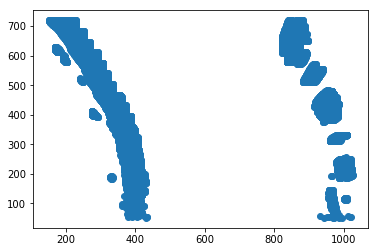

In [268]:
y, x = np.nonzero(lane_lines)
plt.scatter(x, 720-y)

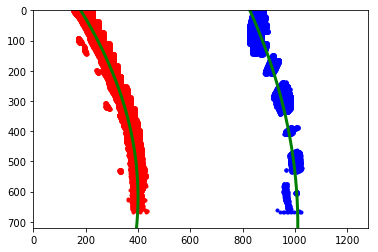

In [269]:

# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
y, x = np.nonzero(lane_lines)
leftx, lefty = x[x<750], y[x<750]
rightx, righty = x[x>750], y[x>750]

# First, integer y values for plotting
# Fit the points, getting the three coefficients.
# Finally, plot the line, using the integer y-values.
ploty = np.linspace(0, 719, num=720)
left_fit = np.polyfit(lefty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
# Same for the right lane
right_fit = np.polyfit(righty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the data
mark_size = 3
plt.plot(leftx, lefty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, righty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

In [270]:

# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)
# Example values: 1926.74 1908.48


892.173324512 1374.14208131


In [271]:
# Define conversions in x and y from pixels space to meters
xm_per_pix = 3.7 / 650     # meters per pixel in x dimension (lane width in US = 3.7 m)
ym_per_pix = 3.0 / 80       # meters per pixel in y dimension (dashed marker length in US = 3.0 m)
cam_pos_x = 1280 / 2.       # camera x-position in pixel (center of image)

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m


216.245148185 m 339.450376631 m


In [272]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # Left and right lane curvature in meters. Used to sanity check new frames.
        self.leftcurve = 0
        self.rightcurve = 0
         
    def send_frame_data():
        
    def get_lane_data():
        
    

IndentationError: expected an indented block (<ipython-input-272-22a181b36658>, line 10)

Sanity Check

    Ok, so your algorithm found some lines. Before moving on, you should check that the detection makes sense. 
    To confirm that your detected lane lines are real, you might consider:

    Checking that they have similar curvature
    Checking that they are separated by approximately the right distance horizontally
    Checking that they are roughly parallel

Look-Ahead Filter

    Once you've found the lane lines in one frame of video, and you are reasonably confident they are actually the lines you are looking for, you don't need to search blindly in the next frame. You can simply search within a window around the previous detection.

    For example, if you fit a polynomial, then for each y position, you have an x position that represents the lane center from the last frame. Search for the new line within +/- some margin around the old line center.

    Double check the bottom of the page here to remind yourself how this works.

    Then check that your new line detections makes sense (i.e. expected curvature, separation, and slope).

Reset

    If your sanity checks reveal that the lane lines you've detected are problematic for some reason, you can simply assume it was a bad or difficult frame of video, retain the previous positions from the frame prior and step to the next frame to search again. If you lose the lines for several frames in a row, you should probably start searching from scratch using a histogram and sliding window, or another method, to re-establish your measurement.

Smoothing

    Even when everything is working, your line detections will jump around from frame to frame a bit and it can be preferable to smooth over the last n frames of video to obtain a cleaner result. Each time you get a new high-confidence measurement, you can append it to the list of recent measurements and then take an average over n past measurements to obtain the lane position you want to draw onto the image.

Drawing

    Once you have a good measurement of the line positions in warped space, it's time to project your measurement back down onto the road! Let's suppose, as in the previous example, you have a warped binary image called warped, and you have fit the lines with a polynomial and have arrays called ploty, left_fitx and right_fitx, which represent the x and y pixel values of the lines. You can then project those lines onto the original image as follows:

In [273]:
def yellowandwhite(hsv_image):
    masks = []
    # First, we define what values, in hsv format, define yellow and white.
    low_white,  high_white =  np.array([0, 0, 200]),  np.array([200, 30, 255])
    low_yellow, high_yellow = np.array([15, 70, 205]),np.array([25, 255, 255])
    
    # Then, we use those thresholds to extract the colors we want from the image.
    white = cv2.inRange(hsv_image, low_white, high_white)
    masks.append(white)
    yellow = cv2.inRange(hsv_image, low_yellow, high_yellow)
    masks.append(yellow)
    
    #Finally, we convert the masks to binary with a low threshold and return.
    yawbinary = np.zeros_like(hsv_image[:,:,0])
    yawbinary[(cv2.add(*masks) >= 20)] = 1
    return yawbinary

In [274]:
def sobelthis(gray_image):
    # Sobel is a filter for left edges that is convolved over the image. 
    # Then we take the absolute value to retreive the right edges.
    # Finally, we scale this to between 0-255
    sobelx = cv2.Sobel(gray_image, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshholding. Create a blank image or zeroes. 
    # Changing to 1 if the pixel value was within the threshold values.
    thresh_min, thresh_max = (20, 100)
    binary = np.zeros_like(scaled_sobel)
    binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return binary

In [275]:
def OR_binaryimage(image1, image2):
    combined_binary = np.zeros_like(image1)
    combined_binary[(image1 == 1) | (image2 == 1)] = 1
    return combined_binary

def AND_binaryimage():
    combined_binary = np.zeros_like(image1)
    combined_binary[(image1 == 1) & (image2 == 1)] = 1
    return combined_binary

In [276]:
def first2bird(image):
    image_width, image_height = image.shape[1], image.shape[0]
    #src is a list of starting locations, dst is where those points finish at.
    #In this case, we're straigtening two subsections of the lanes near us, 
    #which straightenes the rest of the image as well. 
    src = np.float32 ([
            [220, 650],
            [350, 577],
            [828, 577],
            [920, 650]
        ])
    dst = np.float32 ([
            [260, 650],
            [260, 610],
            [880, 610],
            [880, 650]
        ])
    
    #First, calulate the matrix based on the above points.
    #Then, use the matrix to do the transformaton and save the result, then return it.
    M = cv2.getPerspectiveTransform(src, dst) 
    image_warped = cv2.warpPerspective(image, M, (image_width, image_height)) 
    return image_warped

In [277]:
def bird2first(image):
    image_width, image_height = image.shape[1], image.shape[0]
    #src is a list of starting locations, dst is where those points finish at.
    #In this case, we're straigtening two subsections of the lanes near us, 
    #which straightenes the rest of the image as well. 
    src = np.float32 ([
            [220, 650],
            [350, 577],
            [828, 577],
            [920, 650]
        ])
    dst = np.float32 ([
            [260, 650],
            [260, 610],
            [880, 610],
            [880, 650]
        ])
    
    #First, calulate the matrix based on the above points.
    #Then, use the matrix to do the transformaton and save the result, then return it.
    Minv = cv2.getPerspectiveTransform(dst, src)
    image_unwarped = cv2.warpPerspective(image, Minv, (image_width, image_height))
    return image_unwarped

In [278]:
sobel_all = OR_binaryimage(sobelthis(rgb[:,:,0]), OR_binaryimage(sobelthis(rgb[:,:,2]), sobelthis(rgb[:,:,1])))

In [279]:
combined_all = OR_binaryimage(yellowandwhite(hsv), sobel_all)

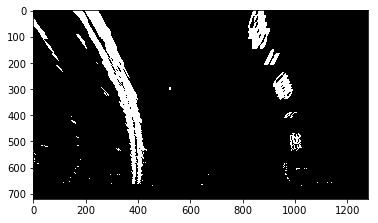

In [280]:
plt.imshow(birdeye_transform(sobel_all), cmap='gray')
plt.show()

In [281]:
def Force3D(mask, image):
    
    masked_image = np.zeros_like(image)
    
    for i in range(3): 
        masked_image[:,:,i] = mask.copy()
        
    return masked_image

In [282]:
image = utils.load_image("./test_images/test1.jpg")
hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

In [283]:
def binarify(hsv):

    yaw_binary = yellowandwhite(hsv)

    #Save a copy of a converted to grayscale image.
    gray = hsv[:,:,2]

    sobel_gray = sobelthis(gray)

    # Threshholding. 
    yawbinary = np.zeros_like(yaw)
    yawbinary[(yaw >= 20)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, yawbinary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(yawbinary == 1) | (sxbinary == 1)] = 1

In [284]:
def ProcessImage(image):
    
    utils.undistort(image)
    
    height, width = image.shape[:2]
    
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    binary_image = binarify(hsv_image)

    masked_image = Force3D(color_mask, image) 

    edge_mask = AutoCanny(masked_image)   #new
      
    edged_image = Force3D(edge_mask, image) 
    
    p1,p2,p3,p4  = [10,height-10],[int(29/60*width),int(9/16*height)],[int(31/60*width),int(9/16*height)],[width-10,height-10]
    points = np.array([p1,p2,p3,p4], dtype=np.int32) 
    region_image= RegionOfInterest(edged_image, points) 
    
    grey_image = cv2.cvtColor(region_image, cv2.COLOR_RGB2GRAY)
    
    return grey_image

In [285]:
global left_lane_line, right_lane_line
left_lane_line, right_lane_line = [],[]

def LaneLineDetector(original_image):
    
    image = np.copy(original_image)
    global width,height
    height,width = image.shape[0],image.shape[1]
    
    processed_image = ProcessImage(image)

    lines = ImageToLines(processed_image) #new
    
    leftx,lefty,rightx,righty = HoughlinesToLanelines(lines)
    
    rightmxb = np.polyfit(rightx,righty,1)
    leftmxb = np.polyfit(leftx,lefty,1)
    
    fl = np.poly1d(leftmxb)
    fr = np.poly1d(rightmxb)
    
    
    horizon = height/1.65
    lx1,lx2,rx1,rx2 = int(min(leftx)),int(FofY(horizon,leftmxb)),int(FofY(horizon,rightmxb)),int(max(rightx))
    ly1,ly2,ry1,ry2 = int(fl(lx1)),int(fl(lx2)),int(fr(rx1)),int(fr(rx2))
    
    lined_image = np.zeros_like(image) 
    cv2.line(lined_image, (lx1,ly1), (lx2, ly2), [0,0,255], 5) 
    cv2.line(lined_image, (rx1,ry1), (rx2, ry2), [0,0,255], 5)
    

    laned_image = cv2.addWeighted(original_image, 0.8, lined_image, 1, 0) 

    return laned_image 

# Tests

## Yellow line video

In [286]:
yellow_clip_output = 'solidYellowLeft1.mp4'
clip2 = VideoFileClip("MathMagicMachine/TestVideos/solidYellowLeft.mp4")
yellow_clip = clip2.fl_image(LaneLineDetector)
%time yellow_clip.write_videofile(yellow_clip_output, audio=False)

OSError: MoviePy error: the file MathMagicMachine/TestVideos/solidYellowLeft.mp4 could not be found !
Please check that you entered the correct path.

In [ ]:
HTML("""
<video width="960" height="520" controls>
  <source src="{0}" type="video/mp4">
</video>
""".format(yellow_clip_output))

## Challenge video

In [ ]:
final_clip_output = 'challenge2.mp4'
clip = VideoFileClip("MathMagicMachine/TestVideos/challenge.mp4")
final_clip = clip.fl_image(LaneLineDetector)
%time final_clip.write_videofile(final_clip_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="520" controls>
  <source src="{0}" type="video/mp4">
</video>
""".format(final_clip_output))

## White line video

In [ ]:
white_clip_output = 'solidWhiteRight1.mp4'
clip1 = VideoFileClip("TestVideos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(LaneLineDetector)
%time white_clip.write_videofile(white_clip_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="520" controls>
  <source src="{0}" type="video/mp4">
</video>
""".format(white_clip_output))